<a href="https://colab.research.google.com/github/ipeirotis-org/datasets/blob/main/ERCOT/ERCOT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ERCOT Electricity Load Data Pipeline

This notebook downloads, processes, and uploads ERCOT (Electric Reliability Council of Texas) hourly electricity load data to BigQuery.

**Data Source:** [ERCOT Grid Information - Load](http://www.ercot.com/gridinfo/load)  
**Historical Archives:** [ERCOT Load History](http://www.ercot.com/gridinfo/load/load_hist)

**Note:** There is a ~1% difference between real-time telemetry data and historical archives (which use final settled values). This dataset uses the historical archives.

## Setup and Configuration

In [1]:
# Install dependencies (Colab)
!pip install -q google-cloud-bigquery pandas pyarrow openpyxl xlrd

In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import calendar
import re
import os
import subprocess
from pathlib import Path

# Plotting setup
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 4)
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.color'] = 'lightgray'
plt.rcParams['font.size'] = 10

In [3]:
# =============================================================================
# CONFIGURATION - Update these values for your environment
# =============================================================================

PROJECT_ID = "nyu-datasets"  # Your Google Cloud project ID
DATASET_ID = "ercot"
TABLE_ID = "electricity"

# Standard column names for the final dataset
STANDARD_COLUMNS = ['COAST', 'EAST', 'FWEST', 'NORTH', 'NCENT', 'SOUTH', 'SCENT', 'WEST', 'ERCOT']

In [4]:
# BigQuery Authentication (for Google Colab)
from google.colab import auth
from google.cloud import bigquery

auth.authenticate_user()
client = bigquery.Client(project=PROJECT_ID)

## Data Source Configuration

ERCOT data files have different formats and URLs across years. The URLs don't follow a predictable pattern, so we define them explicitly.

In [35]:
# =============================================================================
# EXPLICIT URL CONFIGURATION FOR ALL YEARS
# URLs extracted from ERCOT website - they don't follow a predictable pattern
# =============================================================================

DATA_SOURCES = {
    # Modern format (2019-2024): ZIP with XLSX, 'Hour Ending' column
    2025: {
        'url': 'https://www.ercot.com/files/docs/2025/02/11/Native_Load_2025.zip',
        'is_zip': True,
        'inner_file': 'Native_Load_2025.xlsx',
        'date_col': 'Hour Ending',
        'needs_rename': False
    },
    2024: {
        'url': 'https://www.ercot.com/files/docs/2024/02/06/Native_Load_2024.zip',
        'is_zip': True,
        'inner_file': 'Native_Load_2024.xlsx',
        'date_col': 'Hour Ending',
        'needs_rename': False
    },
    2023: {
        'url': 'https://www.ercot.com/files/docs/2023/02/09/Native_Load_2023.zip',
        'is_zip': True,
        'inner_file': 'Native_Load_2023.xlsx',
        'date_col': 'Hour Ending',
        'needs_rename': False
    },
    2022: {
        'url': 'https://www.ercot.com/files/docs/2022/02/08/Native_Load_2022.zip',
        'is_zip': True,
        'inner_file': 'Native_Load_2022.xlsx',
        'date_col': 'Hour Ending',
        'needs_rename': False
    },
    2021: {
        'url': 'https://www.ercot.com/files/docs/2021/11/12/Native_Load_2021.zip',
        'is_zip': True,
        'inner_file': 'Native_Load_2021.xlsx',
        'date_col': 'Hour Ending',
        'needs_rename': False
    },
    2020: {
        'url': 'https://www.ercot.com/files/docs/2021/01/12/Native_Load_2020.zip',
        'is_zip': True,
        'inner_file': 'Native_Load_2020.xlsx',
        'date_col': 'HourEnding',
        'needs_rename': False
    },
    2019: {
        'url': 'https://www.ercot.com/files/docs/2020/01/09/Native_Load_2019.zip',
        'is_zip': True,
        'inner_file': 'Native_Load_2019.xlsx',
        'date_col': 'HourEnding',
        'needs_rename': False
    },

    # 2018: ZIP with XLSX, but uses 'HourEnding' (no space)
    2018: {
        'url': 'https://www.ercot.com/files/docs/2019/01/07/native_load_2018.zip',
        'is_zip': True,
        'inner_file': 'Native_Load_2018.xlsx',
        'date_col': 'HourEnding',
        'needs_rename': False
    },

    # 2016-2017: ZIP with XLSX, 'Hour Ending' column
    2017: {
        'url': 'https://www.ercot.com/files/docs/2018/01/09/native_load_2017.zip',
        'is_zip': True,
        'inner_file': 'native_Load_2017.xlsx',  # Note: lowercase 'native'
        'date_col': 'Hour Ending',
        'needs_rename': False
    },
    2016: {
        'url': 'https://www.ercot.com/files/docs/2017/01/10/native_Load_2016.zip',
        'is_zip': True,
        'inner_file': 'native_Load_2016.xlsx',
        'date_col': 'Hour_End',
        'needs_rename': True
    },

    # 2015: Direct XLS (no zip), 'Hour Ending' column
    2015: {
        'url': 'https://www.ercot.com/files/docs/2016/01/07/native_load_2015.xls',
        'is_zip': False,
        'inner_file': None,
        'date_col': 'Hour_End',
        'needs_rename': True
    },

    # Legacy format (2007-2014): Direct XLS, 'Hour_End' column, different region names
    2014: {
        'url': 'https://www.ercot.com/files/docs/2015/10/22/2014_ercot_hourly_load_data.xls',
        'is_zip': False,
        'inner_file': None,
        'date_col': 'Hour_End',
        'needs_rename': True
    },
    2013: {
        'url': 'https://www.ercot.com/files/docs/2015/10/22/2013_ercot_hourly_load_data.xls',
        'is_zip': False,
        'inner_file': None,
        'date_col': 'Hour_End',
        'needs_rename': True
    },
    2012: {
        'url': 'https://www.ercot.com/files/docs/2015/10/22/2012_ercot_hourly_load_data.xls',
        'is_zip': False,
        'inner_file': None,
        'date_col': 'Hour_End',
        'needs_rename': True
    },
    2011: {
        'url': 'https://www.ercot.com/files/docs/2015/10/22/2011_ercot_hourly_load_data.xls',
        'is_zip': False,
        'inner_file': None,
        'date_col': 'Hour_End',
        'needs_rename': True
    },
    2010: {
        'url': 'https://www.ercot.com/files/docs/2015/10/22/2010_ercot_hourly_load_data.xls',
        'is_zip': False,
        'inner_file': None,
        'date_col': 'Hour_End',
        'needs_rename': True
    },
    2009: {
        'url': 'https://www.ercot.com/files/docs/2015/10/22/2009_ercot_hourly_load_data.xls',
        'is_zip': False,
        'inner_file': None,
        'date_col': 'Hour_End',
        'needs_rename': True
    },
    2008: {
        'url': 'https://www.ercot.com/files/docs/2015/10/22/2008_ercot_hourly_load_data.xls',
        'is_zip': False,
        'inner_file': None,
        'date_col': 'Hour_End',
        'needs_rename': True
    },
    2007: {
        'url': 'https://www.ercot.com/files/docs/2015/10/22/2007_ercot_hourly_load_data.xls',
        'is_zip': False,
        'inner_file': None,
        'date_col': 'Hour_End',
        'needs_rename': True
    },
    2006: {
        'url': 'https://www.ercot.com/files/docs/2015/10/22/2006_ercot_hourly_load_data.xls',
        'is_zip': False,
        'inner_file': None,
        'date_col': 'Hour_End',
        'needs_rename': True
    },
    2005: {
        'url': 'https://www.ercot.com/files/docs/2015/10/22/2005_ercot_hourly_load_data.xls',
        'is_zip': False,
        'inner_file': None,
        'date_col': 'Hour_End',
        'needs_rename': True
    },
    2004: {
        'url': 'https://www.ercot.com/files/docs/2015/10/22/2004_ercot_hourly_load_data.xls',
        'is_zip': False,
        'inner_file': None,
        'date_col': 'Hour_End',
        'needs_rename': True
    },
    2003: {
        'url': 'https://www.ercot.com/files/docs/2015/10/22/2003_ercot_hourly_load_data.xls',
        'is_zip': False,
        'inner_file': None,
        'date_col': 'Hour_End',
        'needs_rename': True
    },
    2002: {
        'url': 'https://www.ercot.com/files/docs/2015/10/22/2002_ercot_hourly_load_data.xls',
        'is_zip': False,
        'inner_file': None,
        'date_col': 'Hour_End',
        'needs_rename': True
    },
}

# Column name mappings for legacy data (2002-2014)
LEGACY_COLUMN_RENAMES = {
    'FAR_WEST': 'FWEST',
    'NORTH_C': 'NCENT',
    'SOUTHERN': 'SOUTH',
    'SOUTH_C': 'SCENT'
}

YEARS = sorted(DATA_SOURCES.keys(), reverse=True)
print(f"Configured {len(YEARS)} years: {max(YEARS)} to {min(YEARS)}")

Configured 24 years: 2025 to 2002


## Data Processing Functions

In [36]:
def download_file(url, output_path):
    """Download a file using curl with redirect following."""
    result = subprocess.run(
        ['curl', '-sL', url, '-o', output_path],
        capture_output=True, text=True
    )
    if result.returncode != 0:
        raise RuntimeError(f"Download failed: {result.stderr}")

    # Check if file was actually downloaded
    if not os.path.exists(output_path) or os.path.getsize(output_path) == 0:
        raise RuntimeError(f"Downloaded file is empty or missing: {output_path}")

    return output_path


def extract_zip(zip_path, extract_dir='.'):
    """Extract a ZIP file."""
    result = subprocess.run(
        ['unzip', '-o', zip_path, '-d', extract_dir],
        capture_output=True, text=True
    )
    if result.returncode != 0:
        raise RuntimeError(f"Extraction failed: {result.stderr}")


def parse_datetime(date_str):
    """
    Parse ERCOT datetime strings, handling edge cases:
    - '24:00' hour ending (represents midnight of next day)
    - 'DST' suffix for daylight saving time
    - Various date formats
    """
    if pd.isna(date_str):
        return pd.NaT

    date_str = str(date_str).strip()

    # Remove DST suffix (we'll handle timezone separately)
    date_str = date_str.replace(' DST', '')

    # Handle '24:00' hour ending
    if '24:00' in date_str:
        date_part = date_str.split()[0]
        try:
            base_date = pd.to_datetime(date_part, format='%m/%d/%Y')
        except:
            base_date = pd.to_datetime(date_part)
        return base_date + dt.timedelta(days=1)

    # Try standard formats
    for fmt in ['%m/%d/%Y %H:%M', '%Y-%m-%d %H:%M:%S', '%m/%d/%Y']:
        try:
            return pd.to_datetime(date_str, format=fmt)
        except (ValueError, TypeError):
            continue

    # Fallback to pandas parser
    try:
        return pd.to_datetime(date_str)
    except:
        return pd.NaT


def standardize_dataframe(df, date_col, needs_rename=False):
    """
    Standardize a raw ERCOT dataframe:
    - Rename columns to standard names
    - Parse datetime column
    - Set datetime as index
    - Sort by datetime
    """
    df = df.copy()

    # Rename columns for older data formats
    if needs_rename:
        df = df.rename(columns=LEGACY_COLUMN_RENAMES)

    # Convert date column to string if needed
    df[date_col] = df[date_col].astype(str)

    # Parse datetime
    df['date'] = df[date_col].apply(parse_datetime)

    # Drop original datetime column and set index
    df = df.drop(columns=[date_col])
    df = df.set_index('date')
    df = df.sort_index()

    # Keep only standard columns (in case of extra columns)
    available_cols = [c for c in STANDARD_COLUMNS if c in df.columns]
    df = df[available_cols]

    return df


def validate_dataframe(df, year):
    """
    Validate a processed dataframe for data quality.
    """
    results = {
        'year': year,
        'rows': len(df),
        'missing_values': df.isnull().sum().sum(),
        'duplicate_timestamps': df.index.duplicated().sum(),
    }

    # Expected hours (8760 for normal year, 8784 for leap year)
    # DST changes can cause +/- 1 hour variation
    expected = 8784 if calendar.isleap(year) else 8760
    results['expected_rows'] = expected
    results['row_diff'] = results['rows'] - expected

    return results

In [37]:
def process_year(year, verbose=True):
    """
    Download and process ERCOT data for a single year.
    """
    config = DATA_SOURCES[year]

    if verbose:
        print(f"  Downloading {year}...", end=" ", flush=True)

    # Download
    if config['is_zip']:
        zip_path = f"native_load_{year}.zip"
        download_file(config['url'], zip_path)
        extract_zip(zip_path)
        data_file = config['inner_file']
    else:
        data_file = f"native_load_{year}.xls"
        download_file(config['url'], data_file)

    if verbose:
        print("done. Processing...", end=" ", flush=True)

    # Read Excel file
    df = pd.read_excel(data_file)

    # Standardize
    df = standardize_dataframe(
        df,
        date_col=config['date_col'],
        needs_rename=config['needs_rename']
    )

    # Validate
    validation = validate_dataframe(df, year)

    if verbose:
        status = "✓" if validation['missing_values'] == 0 and abs(validation['row_diff']) <= 2 else "⚠"
        print(f"{status} {validation['rows']} rows")

    return df, validation

## Download and Process All Years

In [38]:
# Process all years
print(f"Processing ERCOT data for {len(YEARS)} years ({min(YEARS)}-{max(YEARS)})\n")

dataframes = {}
validations = []

for year in YEARS:
    try:
        df, validation = process_year(year)
        dataframes[year] = df
        validations.append(validation)
    except Exception as e:
        print(f"  ERROR processing {year}: {e}")
        validations.append({'year': year, 'error': str(e)})

print(f"\nSuccessfully processed {len(dataframes)} years")

Processing ERCOT data for 24 years (2002-2025)


Successfully processed 24 years


In [39]:
# Display validation summary
validation_df = pd.DataFrame(validations)
print("Data Validation Summary:")
print("=" * 60)

if 'error' in validation_df.columns:
    errors = validation_df[validation_df['error'].notna()]
    if len(errors) > 0:
        print(f"\n⚠ {len(errors)} years had errors:")
        print(errors[['year', 'error']])

valid = validation_df[validation_df.get('error').isna()] if 'error' in validation_df.columns else validation_df

print(f"\nTotal rows: {valid['rows'].sum():,}")
print(f"Missing values: {valid['missing_values'].sum()}")
print(f"Duplicate timestamps: {valid['duplicate_timestamps'].sum()}")

# Show years with row count anomalies
anomalies = valid[abs(valid['row_diff']) > 2]
if len(anomalies) > 0:
    print(f"\n⚠ Years with unexpected row counts:")
    print(anomalies[['year', 'rows', 'expected_rows', 'row_diff']])

Data Validation Summary:

Total rows: 208,919
Missing values: 9
Duplicate timestamps: 23

⚠ Years with unexpected row counts:
   year  rows  expected_rows  row_diff
0  2025  7295           8760     -1465


## Concatenate All Years

In [40]:
# Concatenate all dataframes
df_list = [dataframes[year] for year in sorted(dataframes.keys())]
df = pd.concat(df_list, axis='index').sort_index()

# Remove any duplicate timestamps (keeping first occurrence)
initial_len = len(df)
df = df[~df.index.duplicated(keep='first')]
if len(df) < initial_len:
    print(f"Removed {initial_len - len(df)} duplicate timestamps")

print(f"\nCombined dataset:")
print(f"  Shape: {df.shape}")
print(f"  Date range: {df.index.min()} to {df.index.max()}")
print(f"  Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

Removed 23 duplicate timestamps

Combined dataset:
  Shape: (208896, 9)
  Date range: 2002-01-01 01:00:00.003000 to 2025-11-01 00:00:00
  Memory usage: 15.9 MB


In [41]:
# Preview the data
print("First 5 rows:")
display(df.head())

print("\nLast 5 rows:")
display(df.tail())

print("\nData types:")
print(df.dtypes)

First 5 rows:


,COAST,EAST,FWEST,NORTH,NCENT,SOUTH,SCENT,WEST,ERCOT
date,,,,,,,,,
2002-01-01 01:00:00.003,8331.469266,1111.096549,1094.045496,995.298392,10336.304899,2165.007571,4793.193560,843.747177,29670.162911
2002-01-01 01:59:59.997,8107.805431,1091.481584,1083.517981,981.195477,10178.052738,2092.374118,4766.918187,835.488188,29136.833703
2002-01-01 03:00:00.000,7890.721717,1080.257616,1085.038740,971.305257,10100.887710,2042.080714,4702.918892,830.694878,28703.905525
2002-01-01 04:00:00.003,7799.817527,1079.726403,1093.381853,971.262963,10081.565109,2011.935791,4669.064391,835.068413,28541.822450
2002-01-01 04:59:59.997,7815.968171,1087.934961,1106.651296,982.535591,10192.218670,2002.487678,4695.011904,848.598209,28731.406478



Last 5 rows:


,COAST,EAST,FWEST,NORTH,NCENT,SOUTH,SCENT,WEST,ERCOT
date,,,,,,,,,
2025-10-31 20:00:00,12293.099955,1502.115435,7154.663551,1083.185201,12213.669780,3843.448262,7634.015669,1275.258975,46999.456827
2025-10-31 21:00:00,12089.179102,1488.119349,7008.942844,1075.057380,12023.477007,3813.363491,7540.268511,1267.330865,46305.738549
2025-10-31 22:00:00,11972.808850,1484.750094,6995.800625,1067.419576,11886.814617,3664.426578,7389.264298,1233.586646,45694.871284
2025-10-31 23:00:00,11760.871469,1459.196259,6861.796495,1063.416497,11545.073798,3515.971452,7096.213354,1199.212976,44501.752300
2025-11-01 00:00:00,11291.194323,1374.253414,6912.009400,1144.123176,11018.688786,3345.243607,6753.961852,1159.506215,42998.980774



Data types:
COAST    float64
EAST     float64
FWEST    float64
NORTH    float64
NCENT    float64
SOUTH    float64
SCENT    float64
WEST     float64
ERCOT    float64
dtype: object


In [42]:
# Summary statistics
print("Summary Statistics (MW):")
display(df.describe().round(1))

Summary Statistics (MW):


,COAST,EAST,FWEST,NORTH,NCENT,SOUTH,SCENT,WEST,ERCOT
count,208895.0,208895.0,208895.0,208895.0,208895.0,208895.0,208895.0,208895.0,208895.0
mean,11372.3,1461.4,2573.6,1004.7,12835.5,3172.4,6552.6,1100.0,40072.8
std,2988.5,380.3,1799.3,322.1,3696.8,969.7,1997.6,278.2,11209.2
min,1702.8,709.3,843.4,488.3,5819.4,1330.1,2858.3,502.3,19269.8
25%,9182.4,1195.0,1237.6,761.7,10252.8,2434.7,5117.7,896.5,31759.0
50%,10792.4,1381.1,1795.0,931.2,11992.3,3014.5,6110.7,1063.6,37881.1
75%,13031.6,1661.9,3528.3,1159.5,14723.0,3734.3,7628.1,1254.0,46367.5
max,23963.4,3696.7,8773.1,2732.1,28312.5,7155.6,15664.7,2230.5,85464.1


## Visualize the Data

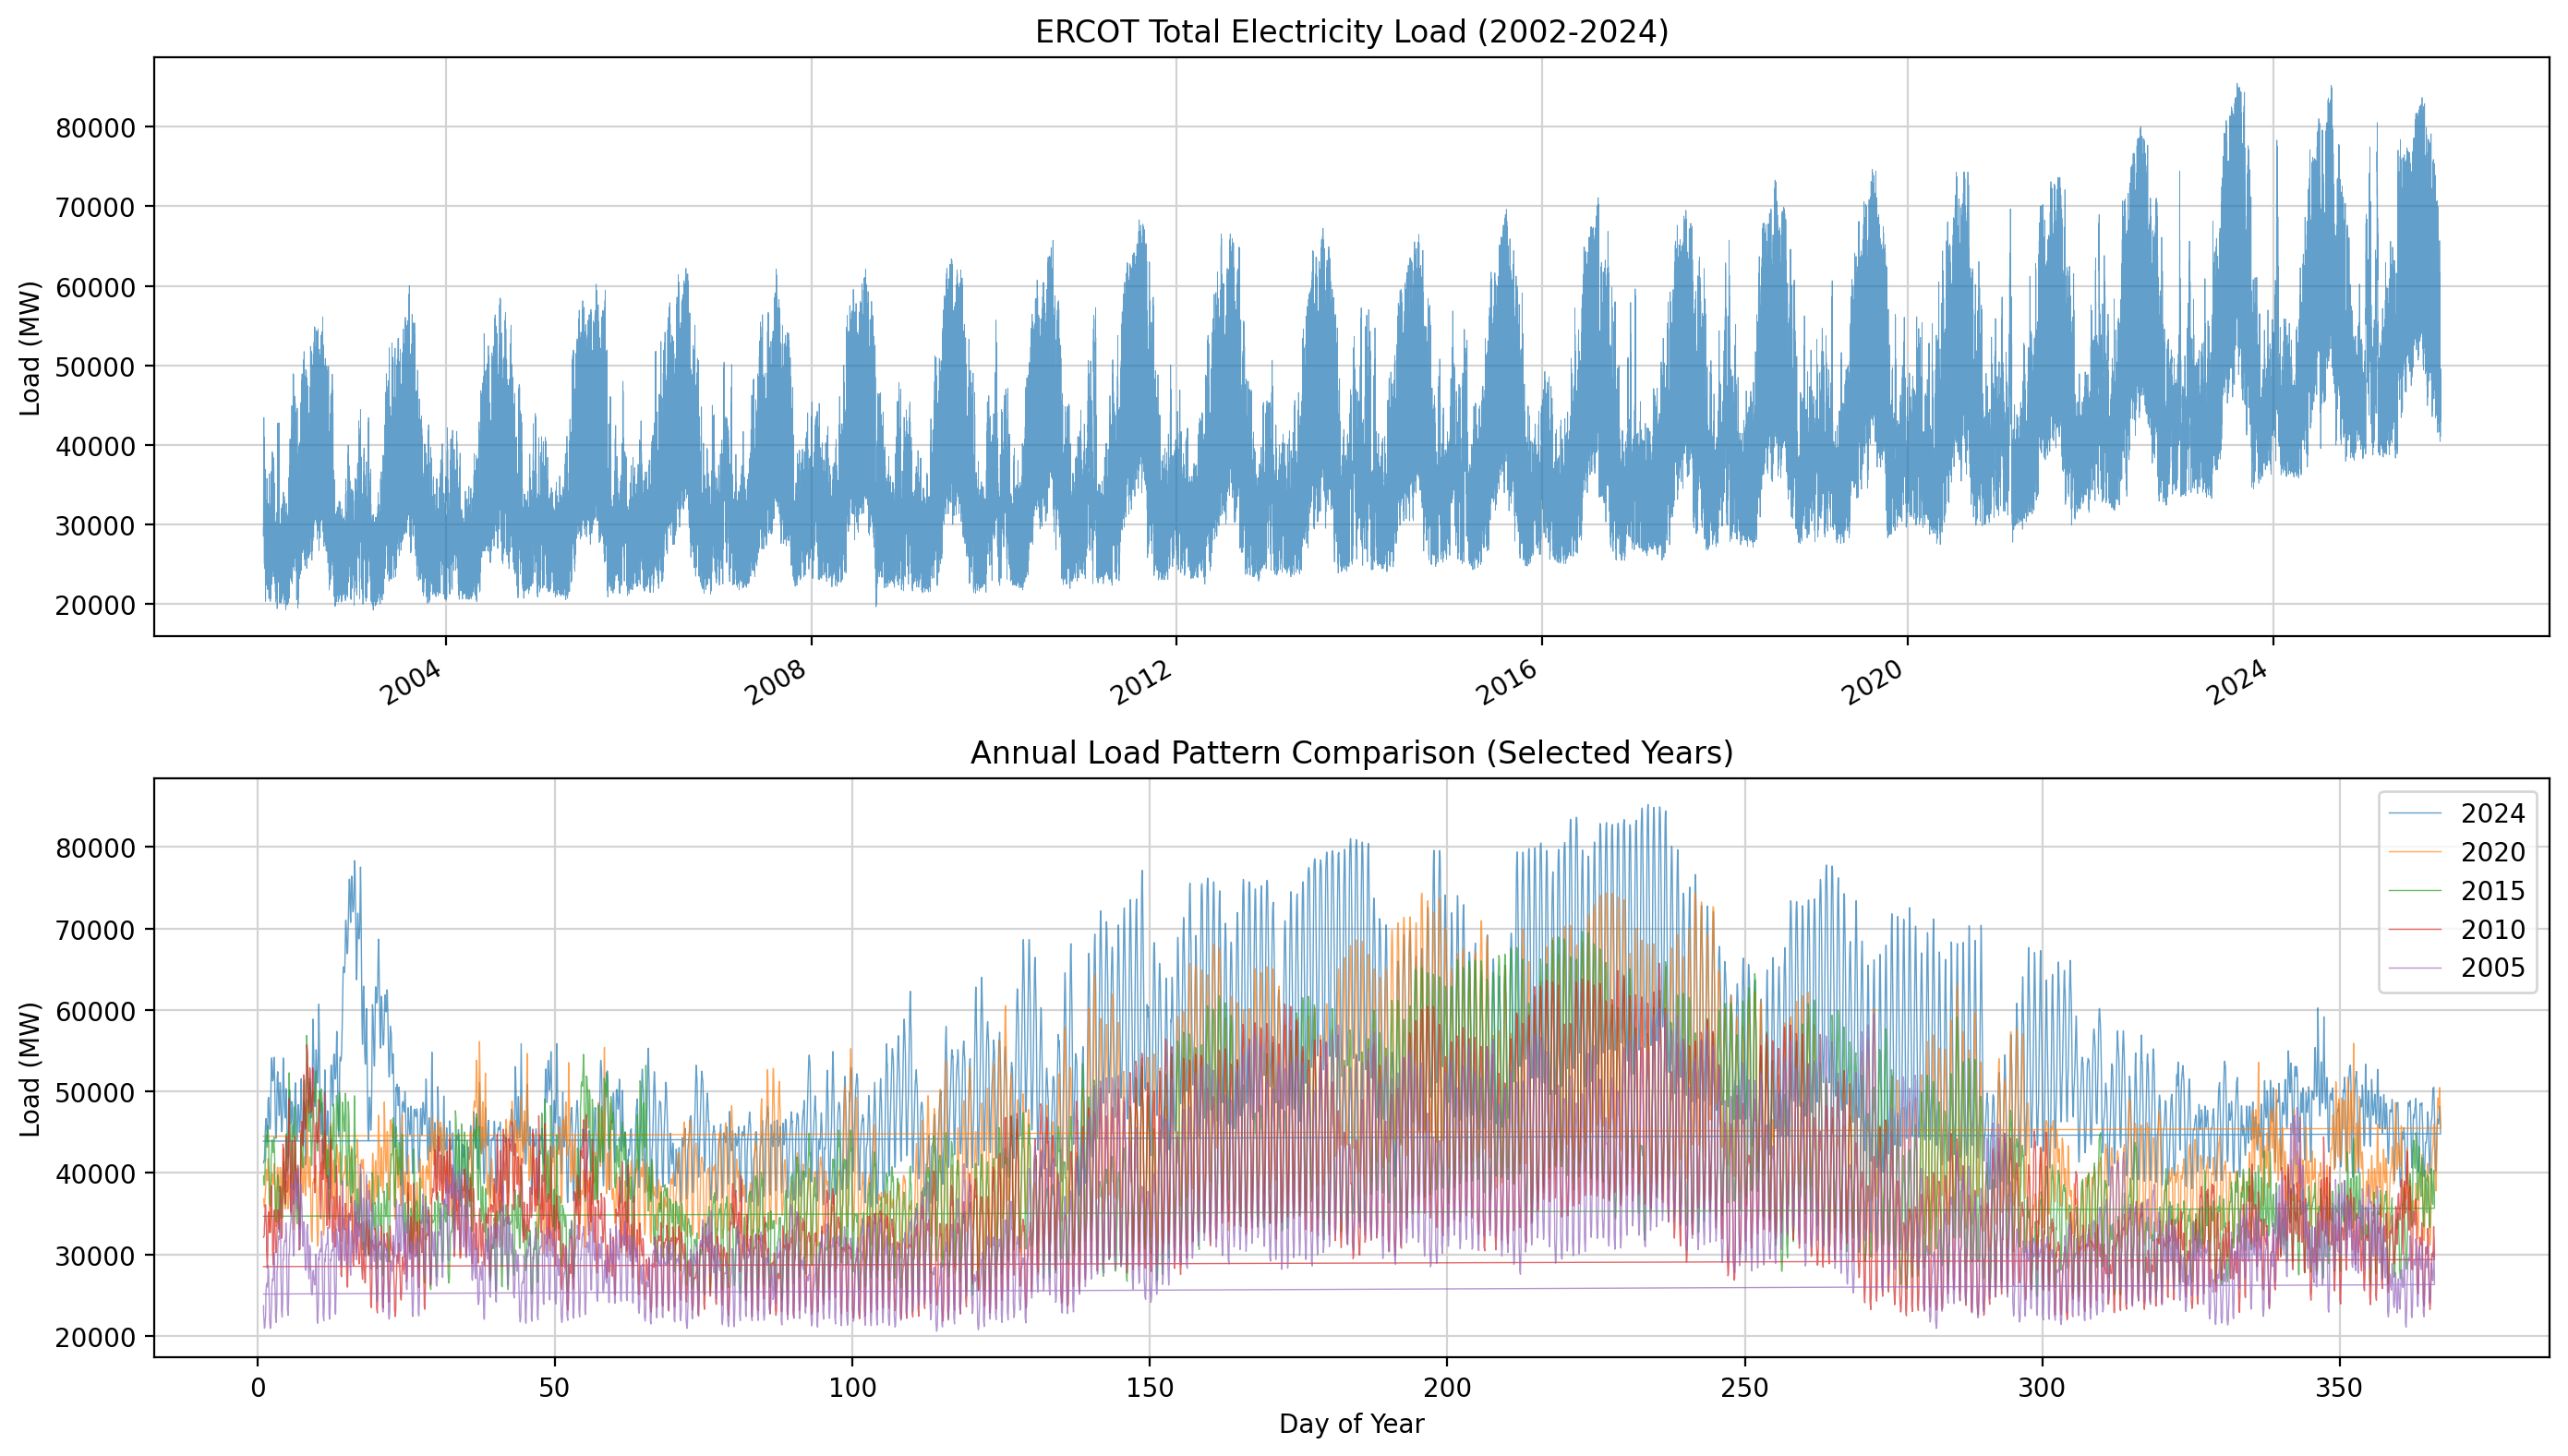

In [43]:
# Plot total ERCOT load over time
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Full time series
ax1 = axes[0]
df['ERCOT'].plot(ax=ax1, linewidth=0.3, alpha=0.7)
ax1.set_title('ERCOT Total Electricity Load (2002-2024)')
ax1.set_ylabel('Load (MW)')
ax1.set_xlabel('')

# Annual pattern (overlay all years)
ax2 = axes[1]
for year in [2024, 2020, 2015, 2010, 2005]:
    if year in dataframes:
        yearly = dataframes[year]['ERCOT'].copy()
        yearly.index = yearly.index.dayofyear + (yearly.index.hour / 24)
        yearly.plot(ax=ax2, label=str(year), linewidth=0.5, alpha=0.7)

ax2.set_title('Annual Load Pattern Comparison (Selected Years)')
ax2.set_ylabel('Load (MW)')
ax2.set_xlabel('Day of Year')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

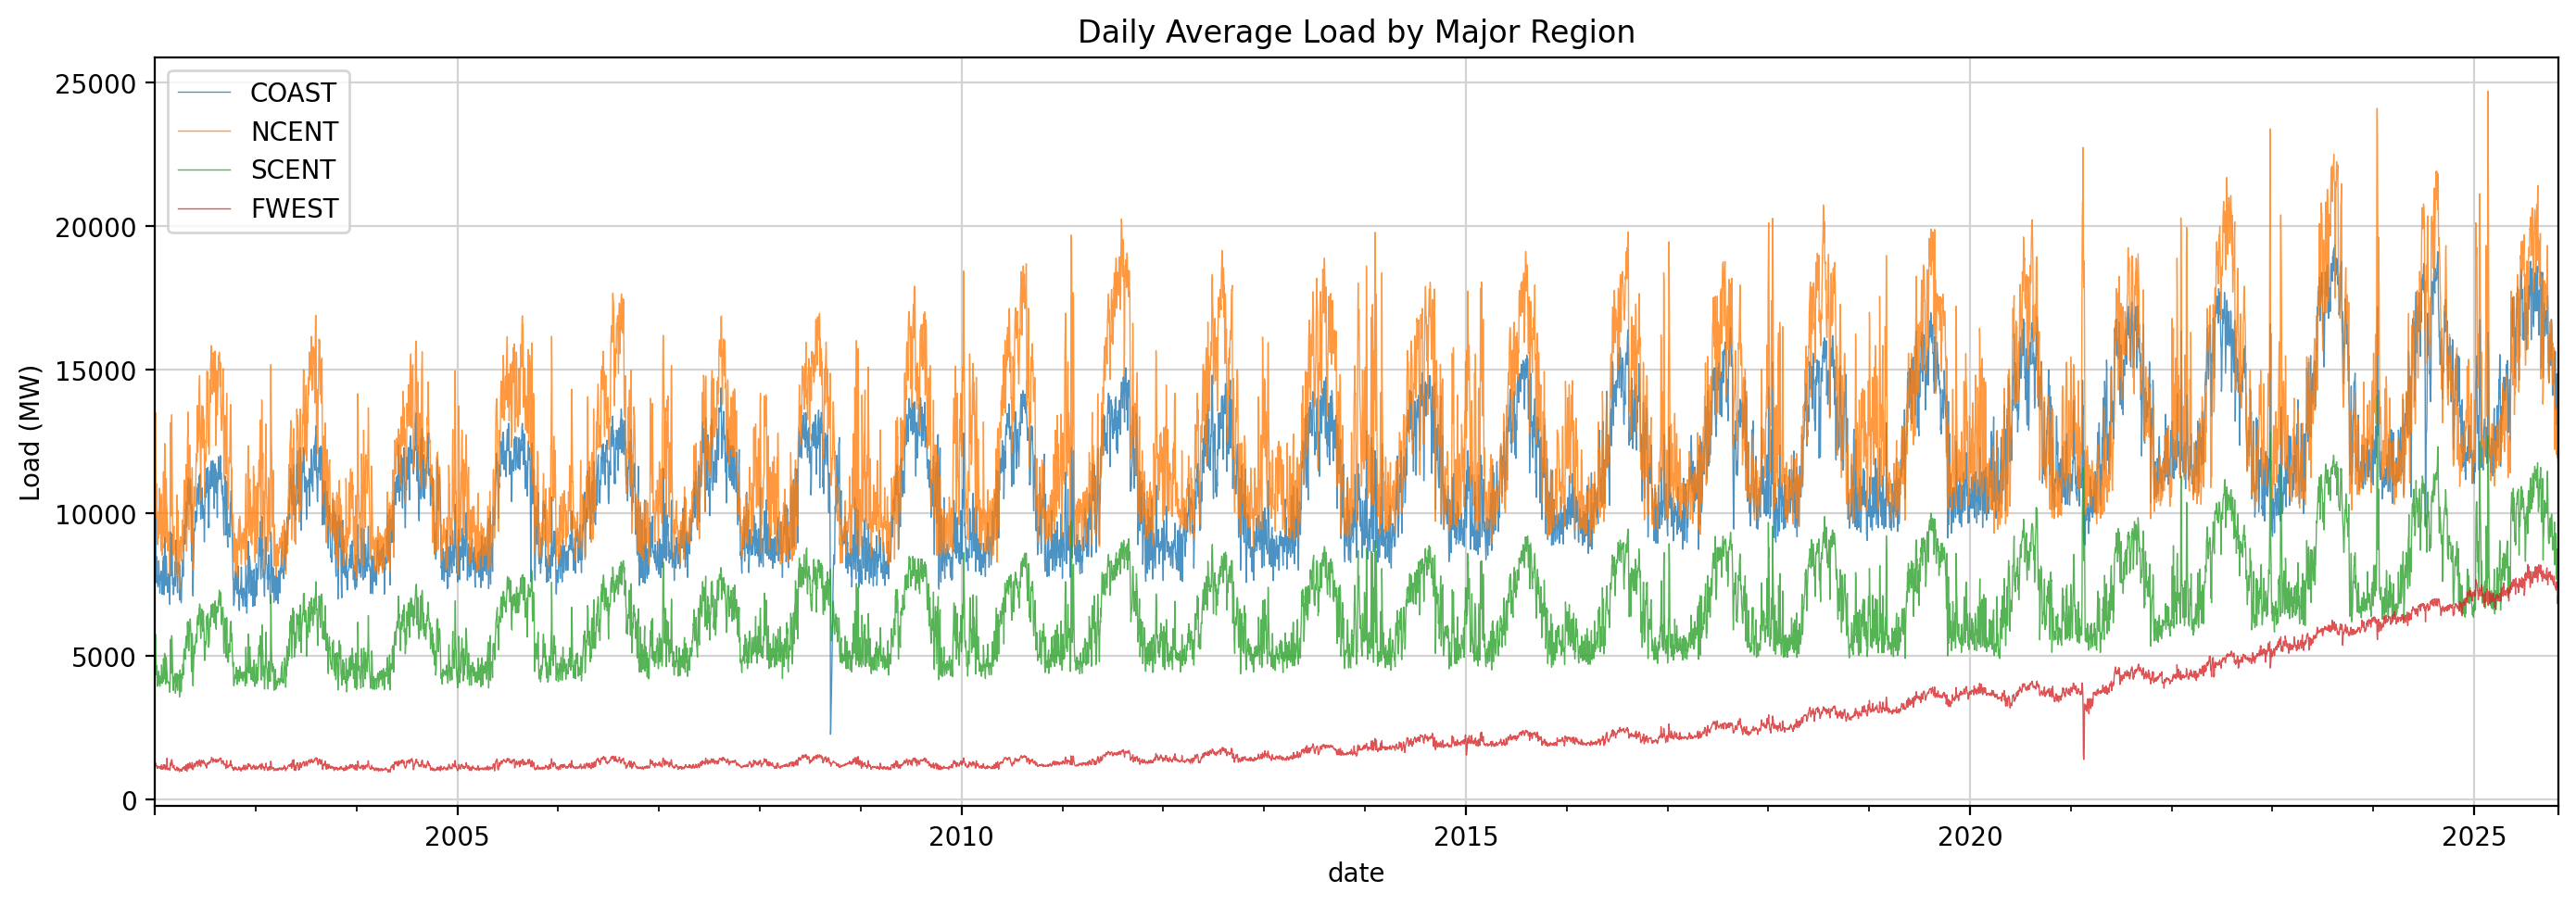

In [44]:
# Regional comparison
fig, ax = plt.subplots(figsize=(14, 5))

# Resample to daily averages for cleaner visualization
df_daily = df.resample('D').mean()
df_daily[['COAST', 'NCENT', 'SCENT', 'FWEST']].plot(ax=ax, linewidth=0.5, alpha=0.8)

ax.set_title('Daily Average Load by Major Region')
ax.set_ylabel('Load (MW)')
ax.legend(loc='upper left')

plt.tight_layout()
plt.show()

## Prepare for BigQuery Upload

In [45]:
# Prepare dataframe for BigQuery
df_bq = df.copy()

# Reset index to make datetime a column
df_bq = df_bq.reset_index()
df_bq = df_bq.rename(columns={'date': 'date_time'})

# Round timestamps to nearest hour (clean up any millisecond variations)
df_bq['date_time'] = df_bq['date_time'].dt.round('h')

# Remove any duplicate timestamps that might have been created by rounding
# This is crucial before tz_localize to avoid AmbiguousTimeError if multiple
# entries round to the same ambiguous local time.
initial_len_pre_tz = len(df_bq)
df_bq = df_bq.drop_duplicates(subset=['date_time'], keep='first')
if len(df_bq) < initial_len_pre_tz:
    print(f"Removed {initial_len_pre_tz - len(df_bq)} duplicate timestamps created by rounding before tz_localize.")


print(f"\nPrepared dataset for BigQuery:")
print(f"  Shape: {df_bq.shape}")
print(f"  Columns: {list(df_bq.columns)}")
display(df_bq.head())


Prepared dataset for BigQuery:
  Shape: (208896, 10)
  Columns: ['date_time', 'COAST', 'EAST', 'FWEST', 'NORTH', 'NCENT', 'SOUTH', 'SCENT', 'WEST', 'ERCOT']


,date_time,COAST,EAST,FWEST,NORTH,NCENT,SOUTH,SCENT,WEST,ERCOT
0,2002-01-01 01:00:00,8331.469266,1111.096549,1094.045496,995.298392,10336.304899,2165.007571,4793.193560,843.747177,29670.162911
1,2002-01-01 02:00:00,8107.805431,1091.481584,1083.517981,981.195477,10178.052738,2092.374118,4766.918187,835.488188,29136.833703
2,2002-01-01 03:00:00,7890.721717,1080.257616,1085.038740,971.305257,10100.887710,2042.080714,4702.918892,830.694878,28703.905525
3,2002-01-01 04:00:00,7799.817527,1079.726403,1093.381853,971.262963,10081.565109,2011.935791,4669.064391,835.068413,28541.822450
4,2002-01-01 05:00:00,7815.968171,1087.934961,1106.651296,982.535591,10192.218670,2002.487678,4695.011904,848.598209,28731.406478


## Upload to BigQuery

In [46]:
# Define BigQuery schema
schema = [bigquery.SchemaField("date_time", "TIMESTAMP", description="Hour ending timestamp (UTC)")]

for col in STANDARD_COLUMNS:
    schema.append(bigquery.SchemaField(
        col,
        "FLOAT",
        description=f"Electricity load in MW - {col} region"
    ))

print("BigQuery Schema:")
for field in schema:
    print(f"  {field.name}: {field.field_type} - {field.description}")

BigQuery Schema:
  date_time: TIMESTAMP - Hour ending timestamp (UTC)
  COAST: FLOAT - Electricity load in MW - COAST region
  EAST: FLOAT - Electricity load in MW - EAST region
  FWEST: FLOAT - Electricity load in MW - FWEST region
  NORTH: FLOAT - Electricity load in MW - NORTH region
  NCENT: FLOAT - Electricity load in MW - NCENT region
  SOUTH: FLOAT - Electricity load in MW - SOUTH region
  SCENT: FLOAT - Electricity load in MW - SCENT region
  WEST: FLOAT - Electricity load in MW - WEST region
  ERCOT: FLOAT - Electricity load in MW - ERCOT region


In [47]:
# Create dataset if it doesn't exist
dataset_ref = f"{PROJECT_ID}.{DATASET_ID}"
dataset = bigquery.Dataset(dataset_ref)
dataset.location = "US"

dataset = client.create_dataset(dataset, exists_ok=True)
print(f"Dataset {dataset_ref} is ready")

Dataset nyu-datasets.ercot is ready


In [48]:
# Upload to BigQuery
table_ref = f"{PROJECT_ID}.{DATASET_ID}.{TABLE_ID}"

# Delete existing table to ensure clean upload
client.delete_table(table_ref, not_found_ok=True)
print(f"Deleted existing table (if any): {table_ref}")

# Configure load job
job_config = bigquery.LoadJobConfig(
    schema=schema,
    write_disposition=bigquery.WriteDisposition.WRITE_TRUNCATE
)

# Upload
print(f"Uploading {len(df_bq):,} rows to {table_ref}...")
job = client.load_table_from_dataframe(df_bq, table_ref, job_config=job_config)

# Wait for completion
job.result()

print(f"✓ Successfully loaded {job.output_rows:,} rows into {table_ref}")

Deleted existing table (if any): nyu-datasets.ercot.electricity
Uploading 208,896 rows to nyu-datasets.ercot.electricity...
✓ Successfully loaded 208,896 rows into nyu-datasets.ercot.electricity


## Verify Upload

In [49]:
# Query to verify the upload
verification_query = f"""
SELECT
    COUNT(*) as total_rows,
    MIN(date_time) as earliest,
    MAX(date_time) as latest,
    AVG(ERCOT) as avg_load,
    MAX(ERCOT) as max_load
FROM `{table_ref}`
"""

result = client.query(verification_query).to_dataframe()
print("Upload Verification:")
display(result)

Upload Verification:


,total_rows,earliest,latest,avg_load,max_load
0,208896,2002-01-01 01:00:00+00:00,2025-11-01 00:00:00+00:00,40072.765958,85464.116394


In [50]:
# Sample data query
sample_query = f"""
SELECT *
FROM `{table_ref}`
ORDER BY date_time
LIMIT 10
"""

sample_df = client.query(sample_query).to_dataframe()
print("Sample data (first 10 rows):")
display(sample_df)

Sample data (first 10 rows):


,date_time,COAST,EAST,FWEST,NORTH,NCENT,SOUTH,SCENT,WEST,ERCOT
0,2002-01-01 01:00:00+00:00,8331.469266,1111.096549,1094.045496,995.298392,10336.304899,2165.007571,4793.193560,843.747177,29670.162911
1,2002-01-01 02:00:00+00:00,8107.805431,1091.481584,1083.517981,981.195477,10178.052738,2092.374118,4766.918187,835.488188,29136.833703
2,2002-01-01 03:00:00+00:00,7890.721717,1080.257616,1085.038740,971.305257,10100.887710,2042.080714,4702.918892,830.694878,28703.905525
3,2002-01-01 04:00:00+00:00,7799.817527,1079.726403,1093.381853,971.262963,10081.565109,2011.935791,4669.064391,835.068413,28541.822450
4,2002-01-01 05:00:00+00:00,7815.968171,1087.934961,1106.651296,982.535591,10192.218670,2002.487678,4695.011904,848.598209,28731.406478
5,2002-01-01 06:00:00+00:00,7978.538695,1101.931823,1133.685759,998.840116,10402.106735,2042.533994,4777.182752,874.835437,29309.655311
6,2002-01-01 07:00:00+00:00,8133.221200,1136.170485,1169.700459,1028.538979,10655.384453,2095.830457,4945.760187,923.410654,30088.016874
7,2002-01-01 08:00:00+00:00,8136.470642,1169.028171,1219.351458,1057.054236,10881.092080,2108.910571,5052.622415,975.941968,30600.471541
8,2002-01-01 09:00:00+00:00,8088.578682,1206.359773,1226.695032,1071.664596,11287.132277,2203.824215,5155.201801,992.500514,31231.956890
9,2002-01-01 10:00:00+00:00,8254.432813,1254.367120,1248.631377,1104.556870,11721.673656,2361.587408,5375.228699,1028.075041,32348.552985


In [51]:
# Check for any gaps in the time series
gap_query = f"""
WITH hourly AS (
    SELECT
        date_time,
        LEAD(date_time) OVER (ORDER BY date_time) as next_time
    FROM `{table_ref}`
)
SELECT
    date_time,
    next_time,
    TIMESTAMP_DIFF(next_time, date_time, HOUR) as gap_hours
FROM hourly
WHERE TIMESTAMP_DIFF(next_time, date_time, HOUR) > 1
ORDER BY date_time

"""

gaps = client.query(gap_query).to_dataframe()
if len(gaps) > 0:
    print(f"⚠ Found {len(gaps)} gaps in the time series:")
    display(gaps)
else:
    print("✓ No gaps found in the time series")

⚠ Found 24 gaps in the time series:


,date_time,next_time,gap_hours
0,2002-04-07 01:00:00+00:00,2002-04-07 03:00:00+00:00,2
1,2003-04-06 01:00:00+00:00,2003-04-06 03:00:00+00:00,2
2,2004-04-04 01:00:00+00:00,2004-04-04 03:00:00+00:00,2
3,2005-04-03 01:00:00+00:00,2005-04-03 03:00:00+00:00,2
4,2006-04-02 01:00:00+00:00,2006-04-02 03:00:00+00:00,2
5,2007-03-11 01:00:00+00:00,2007-03-11 03:00:00+00:00,2
6,2008-03-09 01:00:00+00:00,2008-03-09 03:00:00+00:00,2
7,2009-03-08 01:00:00+00:00,2009-03-08 03:00:00+00:00,2
8,2010-03-14 01:00:00+00:00,2010-03-14 03:00:00+00:00,2
9,2011-03-13 01:00:00+00:00,2011-03-13 03:00:00+00:00,2


## Cleanup

In [52]:
# Optional: Clean up downloaded files
import glob

cleanup = False  # Set to True to delete downloaded files

if cleanup:
    for pattern in ['*.zip', '*.xls', '*.xlsx']:
        for f in glob.glob(pattern):
            os.remove(f)
            print(f"Deleted: {f}")
    print("Cleanup complete")
else:
    print("Skipping cleanup (set cleanup=True to delete downloaded files)")

Skipping cleanup (set cleanup=True to delete downloaded files)


---

## Summary

This notebook:
1. Downloaded ERCOT hourly load data for years 2002-2024
2. Handled various data format changes across years (different URLs, file formats, column names)
3. Standardized column names and parsed datetime values
4. Validated data quality for each year
5. Combined all years into a single dataset
6. Uploaded to BigQuery with proper schema and timestamps

**Next Steps:**
- Build time series forecasting models
- Compare with ERCOT's published forecasts
- Analyze the ~1% difference between telemetry and settled values
- Join with weather data for enhanced modeling